In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller

In [25]:
# Simbol saham dari Yahoo Finance
stocks = ["BBCA.JK", "TLKM.JK", "^JKSE"]  # IHSG sebagai variabel eksogen

# Download data harga penutupan dari Yahoo Finance
data = yf.download(stocks, start="2020-01-01", end="2024-01-01")["Close"]
data = data.dropna()  # Hapus nilai NaN

data.index = pd.date_range(start=data.index[0], periods=len(data), freq="MS")
data.index = pd.to_datetime(data.index)

# Ganti nama kolom untuk memudahkan analisis
data.columns = ["BBCA", "TLKM", "IHSG"]

# Tampilkan beberapa baris awal
print(data.head())

[*********************100%***********************]  3 of 3 completed

                   BBCA         TLKM         IHSG
2020-02-01  6000.032715  3090.178223  6283.581055
2020-03-01  6098.687988  3145.500732  6323.465820
2020-04-01  6040.391113  3129.694336  6257.402832
2020-05-01  6044.875977  3113.887939  6279.346191
2020-06-01  5991.063965  3082.274902  6225.686035


In [26]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

print("Uji Stasioneritas:")
for column in data.columns:
    print(f"\n{column}:")
    adf_test(data[column])

Uji Stasioneritas:

BBCA:
ADF Statistic: -0.5951885964817378
p-value: 0.872065504814621
Non-Stationary

TLKM:
ADF Statistic: -1.2796160952506428
p-value: 0.6384456185055681
Non-Stationary

IHSG:
ADF Statistic: -1.0648911296697148
p-value: 0.7288679877390278
Non-Stationary


In [27]:
# Jika data tidak stasioner (p-value > 0.05), kita lakukan differencing:

data_diff = data.diff().dropna()

In [28]:
# Buat model VARMAX dengan IHSG sebagai variabel eksogen
model = VARMAX(data_diff[["BBCA", "TLKM"]], exog=data_diff["IHSG"], order=(2,1))  # Order=(p,q)
model_fit = model.fit(disp=False)

# Tampilkan ringkasan hasil model
print(model_fit.summary())

C:\Users\Robyi\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Robyi\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


                           Statespace Model Results                           
Dep. Variable:       ['BBCA', 'TLKM']   No. Observations:                  973
Model:                    VARMAX(2,1)   Log Likelihood              -10743.138
                          + intercept   AIC                          21524.275
Date:                Wed, 12 Mar 2025   BIC                          21617.003
Time:                        00:15:59   HQIC                         21559.565
Sample:                    03-01-2020                                         
                         - 03-01-2101                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):        53.63, 131.85
Prob(Q):                        0.99, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.27, 1.03   Skew:                       0.50, 0.44
Prob(H) (two-sided):            0.03,

In [29]:
# Tentukan jumlah langkah prediksi
n_forecast = 10

# Buat input untuk forecasting
exog_forecast = data_diff["IHSG"].iloc[-n_forecast:].values.reshape(-1, 1)
forecast = model_fit.forecast(steps=n_forecast, exog=exog_forecast)

# Konversi hasil ke DataFrame
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq="MS")

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=["BBCA", "TLKM"])

# Mengembalikan data ke skala asli (cumulative sum)
forecast_df = forecast_df.cumsum() + data.iloc[-1]

C:\Users\Robyi\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Robyi\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [30]:
print(forecast_df.index)

DatetimeIndex(['2101-04-01', '2101-05-01', '2101-06-01', '2101-07-01',
               '2101-08-01', '2101-09-01', '2101-10-01', '2101-11-01',
               '2101-12-01', '2102-01-01'],
              dtype='datetime64[ns]', freq='MS')


In [31]:
print(forecast_df["BBCA"].isna().sum())  # Cek jumlah NaN
print(forecast_df["BBCA"].describe())    # Lihat statistik nilai prediksi


0
count      10.000000
mean     9303.359475
std        62.139801
min      9188.933837
25%      9270.144054
50%      9301.571795
75%      9336.960104
max      9406.162255
Name: BBCA, dtype: float64


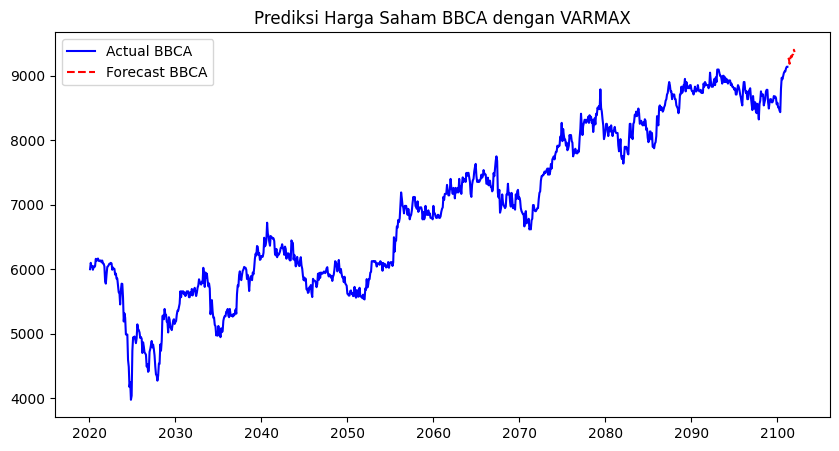

In [32]:
# Plot hasil prediksi
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["BBCA"], label="Actual BBCA", color="blue")
plt.plot(forecast_df.index, forecast_df["BBCA"], label="Forecast BBCA", linestyle="dashed", color="red")
plt.legend()
plt.title("Prediksi Harga Saham BBCA dengan VARMAX")
plt.show()